<a href="https://colab.research.google.com/github/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

```yaml
Generator:
  - Input: 100 (90 noise, 10 one-hot)
  - h1: 150
  - h2: 400
  - h3: 784

FeatureExtractor:
  - Input: 784 (28x28)
  - h1: 400
  - h2: 150
  - h3: 100

Discriminator:
  - Input: 100
  - h1: 50
  - h2: 1

Classifier:
  - Input: 100
  - h1: 50
  - h2: 10
```

Link to file: https://github.com/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/colab.ipynb

In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
data_path = "./data/mnist/"

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=True, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=False, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


In [0]:
x_train = []
x_test = []
y_test = []
y_train = []

In [0]:
def to_one_hot(x):
    b = np.zeros((x.size, 10))
    b[np.arange(x.size), x] = 1
    return b

In [5]:
for data in test_loader:
    y_test_i = data[1].numpy()
    x_test_i = data[0].numpy()
    
    x_test_i = x_test_i.reshape((28, 28))
    y_test_i = y_test_i[0]
    
    x_test.append(x_test_i)
    y_test.append(y_test_i)

In [0]:
y_test = torch.Tensor(to_one_hot(np.array(y_test)))
x_test = torch.Tensor(x_test).reshape((-1, 784))

In [0]:
for data in train_loader:
    y_test_i = data[1].numpy()
    x_test_i = data[0].numpy()
    
    x_test_i = x_test_i.reshape((28, 28))
    y_test_i = y_test_i[0]
    
    x_train.append(x_test_i)
    y_train.append(y_test_i)

y_train = torch.Tensor(to_one_hot(np.array(y_train)))
x_train = torch.Tensor(x_train).reshape((-1, 784))

In [0]:
x_train = x_train[:5000]
x_test = x_test[:500]
y_train = y_train[:5000]
y_test = y_test[:500]

In [9]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train.shape)
print(y_train.shape)

print(torch.min(x_test))
print(torch.max(x_test))
print(y_train[0])

torch.Size([5000, 784]) torch.Size([500, 784]) torch.Size([5000, 10]) torch.Size([500, 10])
torch.Size([5000, 784])
torch.Size([5000, 10])
tensor(0.)
tensor(1.)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


In [0]:
def plot_image(x):
    plt.imshow(x, cmap='gray')
    # plt.show()

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


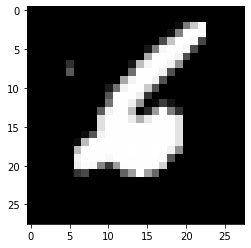

In [11]:
index = 12
plot_image(x_test[index].numpy().reshape((28, 28)))
print(y_test[index])
plt.show()

In [0]:
def get_random(shape, min_=-0.5, max_=0.5):
    return torch.FloatTensor(*shape).uniform_(min_, max_).requires_grad_()

In [0]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((100, 6000)), torch.zeros(6000, requires_grad=True)
        self.w2, self.b2 = get_random((6000, 6000)), torch.zeros(6000, requires_grad=True)
        self.w3, self.b3 = get_random((6000, 784)), torch.zeros(784, requires_grad=True)
    
    def forward(self, x, **kwargs):
        # x.shape = (batch, 100)
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.sigmoid(h1.matmul(self.w2) + self.b2)
        h3 = torch.sigmoid(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()
        
    def zero_grad(self):
        self.w1.grad = torch.zeros(self.w1.grad.shape)
        self.w2.grad = torch.zeros(self.w2.grad.shape)
        self.w3.grad = torch.zeros(self.w3.grad.shape)
        
        self.b1.grad = torch.zeros(self.b1.grad.shape)
        self.b2.grad = torch.zeros(self.b2.grad.shape)
        self.b3.grad = torch.zeros(self.b3.grad.shape)

    @staticmethod
    def getGeneratorInput(y, batch_size):
        gen_input = np.random.uniform(0, 1, (batch_size, 100))
        for batch in range(batch_size):
            for i in range(0, 90, 20):
                gen_input[batch][i: i+10] = y[batch]
        return torch.Tensor(gen_input)

In [22]:
y_sample = y_test[10:12]
print(y_sample)
Generator.getGeneratorInput(y_sample, 2)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])


tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.5750, 0.3600, 0.9441, 0.2569, 0.6121, 0.5046, 0.6036, 0.9645,
         0.4203, 0.1634, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.5948, 0.1941, 0.2706, 0.3593, 0.1861, 0.5125,
         0.4905, 0.1288, 0.9559, 0.7389, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6754, 0.1413, 0.6784, 0.0211,
         0.8720, 0.1800, 0.2959, 0.5373, 0.6037, 0.1711, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2909, 0.2398,
         0.9086, 0.5008, 0.5413, 0.9529, 0.8104, 0.5412, 0.6065, 0.9425, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.5973, 0.0743, 0.4266, 0.1992, 0.1612, 0.5754, 0.3628, 0.7228, 0.7439,
         0.1054],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0

In [0]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((784, 600)), torch.zeros(600, requires_grad=True)
        self.w2, self.b2 = get_random((600, 600)), torch.zeros(600, requires_grad=True)
        self.w3, self.b3 = get_random((600, 100)), torch.zeros(100, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.sigmoid(h1.matmul(self.w2) + self.b2)
        h3 = torch.sigmoid(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()

In [0]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((784, 600)), torch.zeros(600, requires_grad=True)
        self.w2, self.b2 = get_random((600, 600)), torch.zeros(600, requires_grad=True)
        self.w3, self.b3 = get_random((600, 2)), torch.zeros(2, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.sigmoid(h1.matmul(self.w2) + self.b2)
        h3 = torch.sigmoid(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()

    @staticmethod
    def generate_labels(sample_size, real=True):
        labels = torch.zeros((sample_size, 2))
        for sample in labels:
            sample[0] = 1 if real else 0
            sample[1] = 0 if real else 1
        return labels

In [0]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((784, 600)), torch.zeros(600, requires_grad=True)
        self.w2, self.b2 = get_random((600, 600)), torch.zeros(600, requires_grad=True)
        self.w3, self.b3 = get_random((600, 10)), torch.zeros(10, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.sigmoid(h1.matmul(self.w2) + self.b2)
        h3 = torch.nn.functional.softmax(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()

In [0]:
# fe = FeatureExtractor()
# classifier = Classifier()
discriminator = Discriminator()
generator = Generator()

# Selective GAN

In [31]:
batch_size = 200
epochs = 50

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    losses = [0, 0, 0, 0]
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
    
        
        # ------------ Train with real image ----------------
        real = Discriminator.generate_labels(batch_size)
        fake = Discriminator.generate_labels(batch_size, real=False)
        
        features = fe(x_batch)
        discriminator_out = discriminator(features)
        classifier_out = classifier(features)
        
        loss_discriminator = torch.nn.functional.binary_cross_entropy(discriminator_out, real)
        loss_classifier = torch.nn.functional.binary_cross_entropy(classifier_out, y_batch)
        
        loss = loss_discriminator + loss_classifier
        loss.backward()
        discriminator.optimize(0.1)
        classifier.optimize(0.1)
        fe.optimize(0.1)
        
        losses[0] += float(loss)
        
        # --------------- Train with fake image -------------------

        generator_input = Generator.getGeneratorInput(y_batch, batch_size)
        
        generated = generator(generator_input)
        features = fe(generated)
        discriminator_out = discriminator(features)
        classifier_out = classifier(features)
        
        loss_discriminator = torch.nn.functional.binary_cross_entropy(discriminator_out, fake)
        loss_generator = torch.nn.functional.binary_cross_entropy(discriminator_out, real)
        loss_classifier = torch.nn.functional.binary_cross_entropy(classifier_out, y_batch)
        loss = loss_discriminator + loss_classifier
        
        loss.backward(retain_graph=True)
        
        discriminator.optimize(0.1)
        fe.optimize(0.1)
        
        generator.zero_grad()
        loss_generator.backward()
        generator.optimize(0.1)
        
        losses[1] += float(loss_discriminator)
        losses[2] += float(loss_classifier)
        losses[3] += float(loss_generator)
        
    print(f'  Losses: {losses}')

Epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


  Losses: [9.351550132036209, 1.2778786085546017, 8.133616596460342, 75.42709064483643]
Epoch: 1
  Losses: [9.05757087469101, 0.9857751689851284, 8.149785697460175, 81.62760186195374]
Epoch: 2
  Losses: [8.716490477323532, 0.6873852722346783, 8.106913149356842, 90.40933609008789]
Epoch: 3
  Losses: [8.599604934453964, 0.5962067469954491, 8.110706865787506, 94.09379148483276]
Epoch: 4
  Losses: [8.44970914721489, 0.47285211831331253, 8.132135719060898, 99.66366767883301]
Epoch: 5
  Losses: [8.331039488315582, 0.39470741897821426, 8.135742872953415, 104.14802312850952]
Epoch: 6
  Losses: [8.28292390704155, 0.36182994674891233, 8.124283373355865, 106.45758533477783]
Epoch: 7
  Losses: [8.183967798948288, 0.2611696068197489, 8.122605741024017, 114.22565650939941]
Epoch: 8
  Losses: [8.109074264764786, 0.26210406702011824, 8.125921905040741, 114.23803949356079]
Epoch: 9
  Losses: [8.075328886508942, 0.2566063590347767, 8.124271303415298, 114.66406726837158]
Epoch: 10
  Losses: [8.0264152884

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


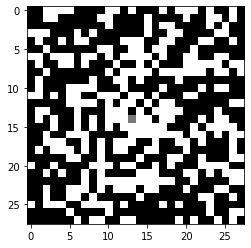

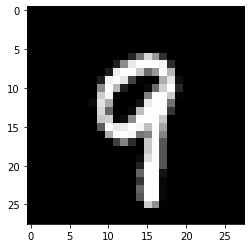

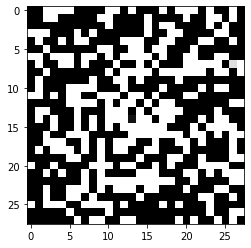

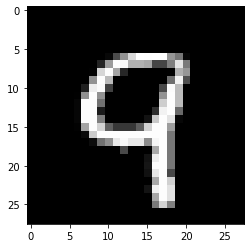

Discriminator_out fake: tensor([[0.0025, 0.9972],
        [0.0025, 0.9973]])
Real Img Discriminator Out: tensor([[9.9947e-01, 3.7344e-04],
        [9.9901e-01, 1.3867e-03]])

Class: tensor([[0.0484, 0.0653, 0.0236, 0.0551, 0.1482, 0.0865, 0.0620, 0.0854, 0.0829,
         0.3426],
        [0.0945, 0.0613, 0.0805, 0.0433, 0.2050, 0.0698, 0.1012, 0.0741, 0.0506,
         0.2197]])
Real class: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


In [33]:
with torch.no_grad():
    
    index = 133
    batch_size = 2
    
    x_sample = x_test[index:index+batch_size]
    y_sample = y_test[index:index+batch_size]
    
    generator_input = Generator.getGeneratorInput(y_sample, batch_size)
        
    generated = generator(generator_input)
    features = fe(generated)
    discriminator_out = discriminator(features)
    
    features = fe(x_sample)
    real_discriminator_out = discriminator(features)
    classifier_out = classifier(features)

    
    for i in range(batch_size):
        plot_image(generated[i].reshape((28, 28)))
        plt.show()
        plot_image(x_sample[i].reshape((28, 28)))
        plt.show()
        
    
    print(f"Discriminator_out fake: {discriminator_out}\nReal Img Discriminator Out: {real_discriminator_out}")
    print(f"\nClass: {classifier_out}\nReal class: {y_sample}")

In [0]:
with torch.no_grad():
    index = 133
    x_sample = x_test[index:index+2]
    y_sample = y_test[index:index+2]
    y_pred = classifier(fe(x_sample))
    print(y_pred)
    print(y_sample)

tensor([[2.8942e-03, 1.3588e-04, 1.3840e-04, 5.9589e-03, 8.2910e-05, 9.7652e-01,
         5.8020e-06, 2.4974e-04, 1.3381e-02, 6.3833e-04],
        [2.8175e-04, 5.9488e-03, 1.7584e-04, 1.1175e-02, 2.4148e-02, 1.2686e-02,
         9.1562e-04, 6.3619e-03, 7.0668e-03, 9.3124e-01]])
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


## GAN Only

In [23]:
batch_size = 200
epochs = 30

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    losses = [0, 0, 0]
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
    
        
        # ------------ Train with real image ----------------
        real = Discriminator.generate_labels(batch_size)
        fake = Discriminator.generate_labels(batch_size, real=False)
        
        discriminator_out = discriminator(x_batch)
        
        loss_discriminator = torch.nn.functional.binary_cross_entropy(discriminator_out, real)
        
        loss_discriminator.backward()

        discriminator.optimize(0.1)
        
        losses[0] += float(loss_discriminator)
        
        # --------------- Train with fake image -------------------

        generator_input = Generator.getGeneratorInput(y_batch, batch_size)
        
        generated = generator(generator_input)
        discriminator_out = discriminator(generated)
        
        loss_discriminator = torch.nn.functional.binary_cross_entropy(discriminator_out, fake)
        loss_generator = torch.nn.functional.binary_cross_entropy(discriminator_out, real)
        
        loss_discriminator.backward(retain_graph=True)
        discriminator.optimize(0.1)
        
        generator.zero_grad()
        loss_generator.backward()
        generator.optimize(0.1)
        
        losses[1] += float(loss_discriminator)
        losses[2] += float(loss_generator)
        
    print(f'  Losses: {losses}')

Epoch: 0
  Losses: [0.3530483739450574, 0.28096380503848195, 113.6924376487732]
Epoch: 1
  Losses: [0.26116274762898684, 0.23398225661367178, 118.25129175186157]
Epoch: 2
  Losses: [0.20324105164036155, 0.18422233685851097, 124.53243446350098]
Epoch: 3
  Losses: [0.24469881132245064, 0.24043961521238089, 117.0921459197998]
Epoch: 4
  Losses: [0.20958232833072543, 0.18413723865523934, 123.65717601776123]
Epoch: 5
  Losses: [0.18742428696714342, 0.18058427749201655, 123.85407304763794]
Epoch: 6
  Losses: [0.19443593779578805, 0.17148704547435045, 125.49542284011841]
Epoch: 7
  Losses: [0.14985075406730175, 0.1196161441039294, 134.96803998947144]
Epoch: 8
  Losses: [0.12452986626885831, 0.11122033977881074, 136.41102266311646]
Epoch: 9
  Losses: [0.11131250788457692, 0.10125416959635913, 138.2896432876587]
Epoch: 10
  Losses: [0.09609002666547894, 0.08715135813690722, 141.90793704986572]
Epoch: 11
  Losses: [0.08344966836739331, 0.06931284465827048, 147.87332487106323]
Epoch: 12
  Losses:

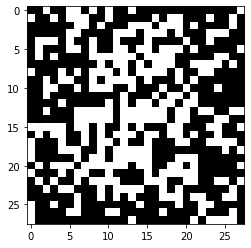

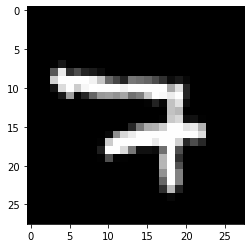

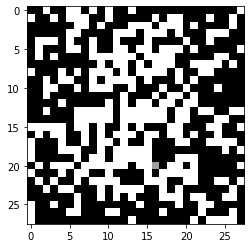

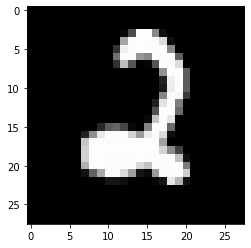

Discriminator_out fake: tensor([[0.0017, 0.9987],
        [0.0018, 0.9987]])
Real Img Discriminator Out: tensor([[9.9994e-01, 1.3468e-05],
        [1.0000e+00, 1.7767e-05]])


In [24]:
with torch.no_grad():
    
    index = 133
    batch_size = 2
    
    x_sample = x_test[index:index+batch_size]
    y_sample = y_test[index:index+batch_size]
    
    generator_input = Generator.getGeneratorInput(y_sample, batch_size)
        
    generated = generator(generator_input)
    discriminator_out = discriminator(generated)
    
    real_discriminator_out = discriminator(x_sample)
    
    for i in range(batch_size):
        plot_image(generated[i].reshape((28, 28)))
        plt.show()
        plot_image(x_sample[i].reshape((28, 28)))
        plt.show()
        
    
    print(f"Discriminator_out fake: {discriminator_out}\nReal Img Discriminator Out: {real_discriminator_out}")